In [119]:
import numpy as np
import pathlib as pl
import os
import pandas as pd
import warnings
warnings.simplefilter("ignore")
from copy import copy
import analysis.retroBO_analysis_functions as fns
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.style.use('mystyle.mplstyle')

inch_conversion = 1/25.4
page_width = 142.4 * inch_conversion
column_width = 67.2 * inch_conversion

# Notebook for Plotting Retrospective Bayesian Optimisation Results

This notebook is for plotting the results of the retrospective Bayesian optimisation on the PCR data.

First specify the results to be plotted.

In [120]:
param_name = 'r' # which parameters
save=False
params = ['r', 'm']

# random_if_none=False
starting_points = ['centre', '0_point_start'] #, '0_point_start', 'centre',
learning_types = ['learning_many', 'learning_1'] #'learning many',

Load the results

In [121]:
res_dfs = {}
results_path = pl.Path(os.getcwd()) / 'results' / 'penalized_bayes_opt'
for key in ['centre_learning_1', '0_point_start_learning_1',
                  'centre_learning_many', '0_point_start_learning_many']:
    res_dfs[key] = pd.read_csv(results_path /f'bayes_opt_{key}.csv', index_col=0)

Check what data is missing and make sure all have 24 seeds

In [122]:
# for key, df in res_dfs.items():
#     res_dfs[key] = df[df['seed']>0]

In [123]:
seeds_df = pd.DataFrame(columns=list(res_dfs.keys()),
                        index=res_dfs[f'{starting_points[0]}_learning_many']['PrimerPairReporter'].unique())

for key, df in res_dfs.items():

    for ppr in df['PrimerPairReporter'].unique():
        df_ = df[df['PrimerPairReporter'] == ppr]
        # counts = df_.value_counts('seed').to_frame()
        seeds_df[key][ppr] = len(df_['seed'].unique())

print(seeds_df)

                      centre_learning_1 0_point_start_learning_1  \
FP001-RP001x-EvaGreen                24                       24   
FP002-RP002x-EvaGreen                24                       24   
FP005-FP001-Probe                    24                       24   
RP001x-FP002-Probe                   24                       24   
RP002x-FP005-Probe                   24                       24   
FP005-FP004-EvaGreen                 24                       24   
FP004-RP004-Probe                    24                       24   
RP002x-FP002-EvaGreen                24                       24   
FP001-RP004-EvaGreen                 24                       24   
FP002-RP004-EvaGreen                 24                       24   
FP004-FP005-Probe                    24                       24   
RP008x-FP005-Probe                   24                       24   
FP005-FP001-EvaGreen                 24                       24   
RP002x-FP004-EvaGreen                24         

If necessary, see which seeds are missing data:

In [124]:
for key, df in res_dfs.items():
    print(key)
    counts_df = pd.DataFrame(columns=res_dfs[f'{starting_points[0]}_learning_1']['PrimerPairReporter'].unique())
    for ppr in df['PrimerPairReporter'].unique():
        df_ = df[(df['PrimerPairReporter'] == ppr)  & (df['model'] == 'mo_indi')][['BP', 'GC', 'seed']].drop_duplicates()
        counts = df_.value_counts('seed').to_frame().sort_values(by='seed')
        counts_df[ppr] = df_.value_counts('seed').to_frame().sort_values(by='seed')
        # seeds_df[key][ppr] = len(df_['seed'].unique())
    print(counts_df.T.to_string())

centre_learning_1
seed                   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24
FP004-RP004-Probe      18  16  16  18  16  16  15  16  17  18  17  18  18  18  18  15  18  18  17  19  16  16  16  15
FP001-RP001x-EvaGreen  16  16  17  15  15  16  17  17  16  16  16  15  16  16  18  15  15  17  16  15  17  16  13  14
FP002-RP002x-EvaGreen  14  15  15  15  14  14  15  15  15  15  15  14  15  15  15  15  15  15  15  15  15  15  15  15
FP001-RP001x-Probe     14  14  12  17  14  14  14  15  15  16  14  14  15  12  15  14  14  17  15  15  15  16  13  17
FP005-FP001-Probe       8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8
RP001x-FP002-Probe     14  14  13  17  14  16  15  16  15  13  14  14  14  14  17  14  11  10  13  14  13  12  13  13
RP002x-FP005-Probe      8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8
FP005-FP004-EvaGreen    8   8   8   8 

In [125]:
df = res_dfs['centre_learning_many']

count_df = df[['PrimerPairReporter', 'seed', 'BP', 'GC']].drop_duplicates()
counts = count_df.value_counts(['PrimerPairReporter', 'seed']).to_frame().sort_values(by=['PrimerPairReporter','seed'])


Calculate the regret

In [126]:
print(params)

['r', 'm']


In [127]:
stzd = True
max_iter = 20

if len(params) > 1:
    regret_metric = 'combined regret'
else:
    regret_metric = 'regret r'
starting_point_names = {'centre':'Centre', '0_point_start':'Model\'s Choice'}
learning_type_names = {'learning_many':'Learning Many', 'learning_1':'Learning One\nat a Time'}
plot_minmax = True
regrets_all = {}
regret_names = []
for name, df in res_dfs.items():
    best_points = fns.get_best_points_penalized(params, df, stzd=stzd, log_t=False)
    regret_df_all = fns.calculate_regret(df, params, best_points, stzd=stzd, penalized=True,
                                         diff_from_target_only=False)
    regret_df_all = regret_df_all[regret_df_all['iteration'] <=max_iter]
    regret_df_all.loc[regret_df_all['combined regret'] <1e-2,  'combined regret'] = 1e-2
    regrets_all[name] = regret_df_all

In [128]:
print(regret_df_all.columns)

Index(['iteration', 'model', 'seed', 'PrimerPairReporter', 'index', 'BP', 'GC',
       'r', 'stzd r', 'r_mu', 'r_sig2', 'r_mu_z', 'r_sig2_z', 'm', 'stzd m',
       'm_mu', 'm_sig2', 'm_mu_z', 'm_sig2_z', 'EI_z', 'target r',
       'target r z', 'target m', 'target m z', 'error r',
       'error from target r z', 'error from target r', 'error r z', 'error m',
       'error from target m z', 'error from target m', 'error m z',
       'initial_surface', 'm penalty', 'diff from target', 'best diff',
       'combined regret', 'diff from target r', 'best diff r', 'regret r',
       'diff from target m', 'best diff m', 'regret m'],
      dtype='object')


In [129]:

cumulative_regrets = {}
for name, regret_df in regrets_all.items():

    if 'r' in params and 'm' in params:
        regret_names = ['combined regret']
    else:
        regret_names = [f'regret {param}' for param in params]

    # if learning_type == 'learning many':
    #     for seed in regret_df['seed'].unique():
    #         temp_df = regret_df[regret_df['seed'] == seed]
    #         if temp_df['iteration'].max() != max_iter:
    #             regret_df= regret_df[regret_df['seed'] != seed]

    regret_df = regret_df.sort_values('iteration')

    # calculate the cumulative minimum regret and cumulative sum of regret

    for model in regret_df['model'].unique():
        for seed in regret_df['seed'].unique():
            for ppr in regret_df['PrimerPairReporter'].unique():
                for regret_name in regret_names:
                    regret_df.loc[
                        (regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                    regret_df['PrimerPairReporter'] == ppr), f'{regret_name} cummin'] = \
                        regret_df.loc[(regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                regret_df['PrimerPairReporter'] == ppr), regret_name].cummin()
                    regret_df.loc[
                        (regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                    regret_df['PrimerPairReporter'] == ppr), f'{regret_name} cumsum'] = \
                        regret_df.loc[(regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                regret_df['PrimerPairReporter'] == ppr), f'{regret_name} cummin'].cumsum()
    cumulative_regrets[name] = regret_df


In [130]:
regret_metrics = {}
for name, regret_df in cumulative_regrets.items():
    # regret_df = regret_df[regret_df['PrimerPairReporter'].str.contains('EvaGreen')]

    i_max = regret_df['iteration'].max() #.loc[regret_df['model'] =='avg',

    for ppr in regret_df['PrimerPairReporter'].unique():

        ppr_imax = regret_df.loc[regret_df['PrimerPairReporter'] == ppr, 'iteration'].to_numpy().max()
        if ppr_imax == i_max:
            pass
        else:
            extra_rows = pd.concat([regret_df.loc[(regret_df['PrimerPairReporter'] == ppr)
                                            & (regret_df['iteration'] == ppr_imax)]] * int((i_max - ppr_imax)))
            extra_rows = extra_rows.sort_values(['model', 'seed'])
            if ppr_imax < (i_max - 1):
                test = np.arange(ppr_imax + 1, i_max + 1).tolist() * int(len(extra_rows)/(i_max-ppr_imax))
                extra_rows['iteration'] = np.arange(ppr_imax + 1, i_max + 1).tolist() \
                                          * int(len(extra_rows)/(i_max-ppr_imax))
                regret_df = regret_df.append(extra_rows)
            elif ppr_imax == (i_max - 1):
                extra_rows['iteration'] = i_max
                regret_df = regret_df.append(extra_rows)
            else:
                pass
    # if 'learning many' in name:
    df = regret_df.groupby(['model', 'iteration', 'seed']).mean().reset_index()

    df2 = df.groupby(['model', 'iteration']).mean().reset_index()
    df3 = df.groupby(['model', 'iteration']).median().reset_index()
    df4 = df.groupby(['model', 'iteration']).quantile(0.05).reset_index()
    df5 = df.groupby(['model', 'iteration']).quantile(0.95).reset_index()
    metrics = ['mean', 'median', 'min', 'max']

    dfs = [df2, df3, df4, df5]
    for i in range(len(dfs)):
        for col in [f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]:
            dfs[i][f'{metrics[i]} {col}'] = dfs[i][col]
        dfs[i] = dfs[i].drop(
            columns=[f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]
                    + ['seed', 'index'] + regret_names)
    regret_df = dfs[0].merge(dfs[1], on=['model', 'iteration'])
    regret_df = regret_df.merge(dfs[2], on=['model', 'iteration'])
    regret_df = regret_df.merge(dfs[3], on=['model', 'iteration'])


    regret_df = regret_df.groupby(['model', 'iteration']).mean().reset_index()
    regret_metrics[name] = regret_df

In [131]:
regret_metrics.keys()

dict_keys(['centre_learning_1', '0_point_start_learning_1', 'centre_learning_many', '0_point_start_learning_many'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


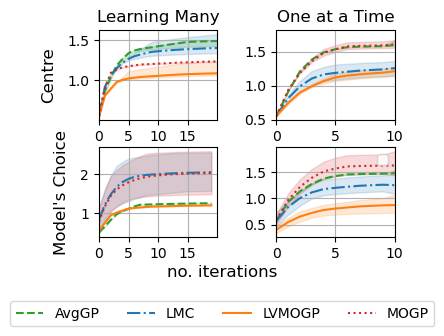

In [132]:
linestyles = {'lmc':'dashdot', 'mo_indi': 'dotted', 'lvm':  'solid' , 'avg': 'dashed' }

colors = fns.get_colors()
starting_point_names = {'centre':'Centre', '0_point_start':'Model\'s Choice'}
learning_type_names = {'learning_many':'Learning Many', 'learning_1':'One at a Time'}
labels = {'mo_indi':'MOGP', 'avg':'AvgGP', 'lmc': 'LMC', 'lvm':'LVMOGP'}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[0.7*page_width, 0.45*page_width])
for i, learning_type in enumerate(learning_types):
    for j, starting_point in enumerate(starting_points):

        regret_df = regret_metrics[f'{starting_point}_{learning_type}']
        for model in regret_df['model'].unique():
            df = regret_df[(regret_df['model'] == model)].sort_values('iteration')
            if (j==0) & (i==0):
                label = labels[model]
            else:
                label = None
            axs[j, i].plot(df['iteration'], df[f'mean {regret_metric} cumsum'], label=label,
                           color=colors[model], linestyle=linestyles[model])
            if plot_minmax:
                axs[j, i].fill_between(df['iteration'], df[f'min {regret_metric} cumsum'],
                                       df[f'max {regret_metric} cumsum'],
                                       alpha=0.17, color=colors[model])
        axs[0, i].set_title(f'{learning_type_names[learning_type]}')
        # axs[j, i].set_ylabel(f'Cum. Regret')
        axs[j, i].set_xlabel(None)
        axs[j, 1].set_ylabel(None)
        axs[j, i].set_xticks([0, 5, 10, 15] )
        axs[j, i].grid()

        if i == 0:
            axs[j, i].set_xlim(0, 20)
        else:
            axs[j, i].set_xlim(0, 10)


fig.legend(loc="lower center", ncols=4,
               bbox_to_anchor=(0.5, -0.2))


rows = [f'{row}' for row in starting_point_names.values()]
for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
    # plt.suptitle('Cumulative Regret')
    axs[j, i].legend()



plt.tight_layout()
fig.supxlabel('no. iterations')
plt.subplots_adjust(hspace=0.3, wspace=0.5, left=None, bottom=0.18, right=None, top=1)


In [133]:
if len(params) >1:
    regret_metric = 'combined regret'
else:
    regret_metric = 'regret r'
win_dfs = {}
win_dfs_cum_regrets = {}
# for i, learning_type in enumerate(['learning many', 'learning 1']):
#     for j, starting_point in enumerate(starting_points):
for name, df in res_dfs.items():
    best_points = fns.get_best_points_penalized(params, df, stzd=stzd, log_t=False)
    regret_df1 = fns.calculate_regret(df, params, best_points, stzd=stzd, penalized=True)
    regret_df1 =regret_df1[regret_df1['iteration']<= max_iter]
    win_df, win_df_totals = fns.get_win_counts(regret_df1, regret_metric)
    win_df_cum_regret, win_df_totals_cum_regret = fns.get_cum_regret_table(regret_df1, regret_name=regret_metric)
    win_dfs[name] = win_df
    win_dfs_cum_regrets[name] = win_df_cum_regret
    print(name)
    print('first to zero')
    print(win_df_totals[['mo_indi','avg','lmc', 'lvm']])
    print('lowest cumulative regret')
    print(win_df_totals_cum_regret[['mo_indi','avg',  'lmc', 'lvm']])

centre_learning_1
first to zero
  mo_indi  avg  lmc  lvm
0     141  137  153  217
lowest cumulative regret
  mo_indi  avg  lmc  lvm
0     173  118  139  204
0_point_start_learning_1
first to zero
  mo_indi  avg lmc  lvm
0      68  100  74  202
lowest cumulative regret
  mo_indi avg lmc  lvm
0      99  62  43  172
centre_learning_many
first to zero
  mo_indi  avg  lmc  lvm
0     142  157  123  165
lowest cumulative regret
  mo_indi  avg  lmc  lvm
0     180  118  100  163
0_point_start_learning_many
first to zero
  mo_indi  avg  lmc  lvm
0      89  122  101  111
lowest cumulative regret
  mo_indi  avg lmc  lvm
0      85  103  84  111


Average number of iterations to best best_points

In [134]:
best_points

,index,PrimerPairReporter,Target Rate,Target Drift,min error from targ comb,error from targ comb r,error from targ comb m
0,0,FP001-RP001x-EvaGreen,0.902,0.16508,0.111973,0.111973,0.000000
1,1,FP002-RP002x-EvaGreen,0.902,0.16508,0.186254,0.186254,0.000000
2,2,FP005-FP001-Probe,0.866,0.16508,0.091401,0.089400,0.000000
3,3,RP001x-FP002-Probe,0.951,0.16508,1.190262,0.112784,0.706707
4,4,RP002x-FP005-Probe,0.866,0.16508,0.297165,0.221764,0.000000
5,5,FP005-FP004-EvaGreen,0.653,0.16508,0.306645,0.306645,0.000000
6,6,FP004-RP004-Probe,0.758,0.16508,0.026603,0.004814,0.000000
7,8,RP002x-FP002-EvaGreen,0.952,0.16508,0.001193,0.001193,0.000000
8,9,FP001-RP004-EvaGreen,1.050,0.16508,0.050663,0.050663,0.000000
9,10,FP002-RP004-EvaGreen,1.050,0.16508,0.824535,0.824535,0.000000


In [135]:
df= regrets_all['centre_learning_many']

print(df[(df['model'] == 'lmc') & (df['PrimerPairReporter'] == 'FP004-RP004-Probe')].sort_values('combined regret').to_string())

       iteration model  seed PrimerPairReporter  index     BP        GC         r    stzd r      r_mu    r_sig2    r_mu_z  r_sig2_z         m    stzd m      m_mu    m_sig2    m_mu_z  m_sig2_z          EI_z  target r  target r z  target m  target m z   error r  error from target r z  error from target r  error r z   error m  error from target m z  error from target m  error m z  error from optimization target z  initial_surface  m penalty  diff from target  best diff  combined regret  diff from target r  best diff r  regret r  diff from target m  best diff m  regret m
9477         6.0   lmc    19  FP004-RP004-Probe   68.0  106.0  0.405660  0.756386  0.185016  0.825293  0.001880  0.610251  0.071597  0.010183  0.185599  0.009848  0.000004  0.147994  0.048998  1.533420e-04     0.758    0.194978      0.01     0.16508  0.068907               0.415273             0.067293   0.425234  0.000335               0.017086             0.000152   0.037605                               NaN             

In [136]:
import math

if len(params) >1:
    regret_metric = 'combined regret'
else:
    regret_metric = 'regret r'
win_dfs = {}
win_dfs_cum_regrets = {}

zero_regret_dicts = {name: {} for name in res_dfs.keys()}
for name, df in res_dfs.items():
    best_points = fns.get_best_points_penalized(params, df, stzd=stzd, log_t=False)
    regret_df1 = fns.calculate_regret(df, params, best_points, stzd=stzd, penalized=True)

    df = regret_df1
    avg_iter_df = pd.DataFrame(columns=['PrimerPairReporter'] + list(df['model'].unique()))
    avg_iter_df['PrimerPairReporter'] = df['PrimerPairReporter'].unique()

    for ppr in df['PrimerPairReporter'].unique():
        zero_regret_dict = {model:[] for model in df['model'].unique()}
        for seed in range(1, 25):
            temp_df = df[(df['PrimerPairReporter'] == ppr) & (df['seed'] == seed)]
            if len(temp_df) < 1:
                pass
            else:
                for model in temp_df['model'].unique():
                    temp_1 = temp_df[(temp_df['model'] == model) & (temp_df[regret_metric] <= 1e-8)]
                    temp_2 = temp_df[(temp_df['model'] == model) & (temp_df['regret r'] <= 0.05)
                                         & (temp_df['regret m'] < 1e-8)]

                    temp_3 = pd.concat([temp_1, temp_2])
                    zero_regret_dict[model].append(np.min(temp_3['iteration']))

        zero_regret_dicts[name][ppr] = zero_regret_dict           
        for model in df['model'].unique():
            if np.isnan(zero_regret_dict[model]).any():
                print(f'{name} {ppr} {model} has {np.isnan(zero_regret_dict[model]).sum()} NaNs')
            avg_iter_df.loc[avg_iter_df['PrimerPairReporter'] == ppr, model] = np.mean(zero_regret_dict[model])
    print(name)
    print(avg_iter_df)
    print(avg_iter_df.dropna(subset=list(df['model'].unique())).mean())

centre_learning_1 FP004-RP004-Probe lmc has 3 NaNs
centre_learning_1 FP004-RP004-Probe lvm has 24 NaNs
centre_learning_1 FP004-RP004-Probe mo_indi has 3 NaNs
centre_learning_1
       PrimerPairReporter  avg       lmc       lvm   mo_indi
0   FP001-RP001x-EvaGreen  5.0  8.458333       4.0       4.0
1      FP001-RP001x-Probe  4.0  4.833333  9.291667       7.0
2    FP001-RP004-EvaGreen  6.0       3.5     1.875       5.0
3   FP002-RP002x-EvaGreen  1.0  3.333333     1.875       1.0
4    FP002-RP004-EvaGreen  1.0       1.0  1.041667       1.0
5       FP004-FP005-Probe  4.0       2.0     4.375       6.0
6       FP004-RP004-Probe  7.0       NaN       NaN       NaN
7    FP005-FP001-EvaGreen  1.0       2.0     1.625       1.0
8       FP005-FP001-Probe  7.0  4.958333  3.791667       2.0
9    FP005-FP004-EvaGreen  0.0       0.0       0.0       0.0
10     RP001x-FP002-Probe  4.0      2.75       1.0  4.916667
11  RP002x-FP002-EvaGreen  1.0       1.0       1.0       1.0
12  RP002x-FP004-EvaGreen  3.0 

In [137]:
print(zero_regret_dicts.values())

dict_values([{'FP001-RP001x-EvaGreen': {'avg': [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0], 'lmc': [10.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 10.0, 8.0, 8.0, 10.0, 8.0, 10.0, 8.0, 8.0, 5.0, 8.0, 10.0, 8.0, 10.0, 9.0, 10.0, 8.0], 'lvm': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], 'mo_indi': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]}, 'FP001-RP001x-Probe': {'avg': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], 'lmc': [5.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, 5.0, 6.0, 5.0, 3.0, 5.0, 5.0, 3.0, 5.0, 6.0], 'lvm': [9.0, 9.0, 9.0, 10.0, 9.0, 9.0, 10.0, 9.0, 10.0, 9.0, 9.0, 10.0, 9.0, 9.0, 10.0, 9.0, 10.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 9.0], 'mo_indi': [7.0

In [138]:
totals = {'avg': [], 'mo_indi': [], 'lmc': [], 'lvm':[]}
totals_dfs = []

for name, dict1 in zero_regret_dicts.items():
    for ppr, dict2 in dict1.items():
        for model_name, iters_list in dict2.items():
            print(name)
            totals[model_name] = totals[model_name] + iters_list
            for i in range(len(iters_list)):
                new_df = pd.DataFrame.from_dict({'test_type':[name], 'model': [model_name], 'seed':[i], 'iteration':[iters_list[i]], 'PrimerPairReporter': [ppr]})
                totals_dfs.append(new_df)
                # print(name)

total_df = pd.concat(totals_dfs)

centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_learning_1
centre_lea

In [139]:
print(total_df.columns)

Index(['test_type', 'model', 'seed', 'iteration', 'PrimerPairReporter'], dtype='object')


In [140]:

for test_type in total_df['test_type'].unique():
    print(test_type)
    if 'centre' in test_type:
        fill = 20
    else:
        fill = 10
    print(total_df[total_df['test_type'] == test_type].fillna(fill).groupby(['model']).mean().reset_index())

centre_learning_1
     model  seed  iteration
0      avg  11.5   3.437500
1      lmc  11.5   3.507812
2      lvm  11.5   3.559896
3  mo_indi  11.5   3.703125
0_point_start_learning_1
     model  seed  iteration
0      avg  11.5   3.062500
1      lmc  11.5   3.458333
2      lvm  11.5   2.520833
3  mo_indi  11.5   3.627604
centre_learning_many
     model  seed  iteration
0      avg  11.5   4.031250
1      lmc  11.5   3.955729
2      lvm  11.5   3.466146
3  mo_indi  11.5   3.562500
0_point_start_learning_many
     model  seed  iteration
0      avg  11.5   3.000000
1      lmc  11.5   3.658854
2      lvm  11.5   2.625000
3  mo_indi  11.5   3.773438


In [107]:
total_df.loc[total_df['test_type'].str.contains('learning_many')].fillna(20)
total_df.loc[total_df['test_type'].str.contains('learning_1')].fillna(20)

,test_type,model,seed,iteration,PrimerPairReporter
0,centre_learning_1,avg,0,5.0,FP001-RP001x-EvaGreen
0,centre_learning_1,avg,1,5.0,FP001-RP001x-EvaGreen
0,centre_learning_1,avg,2,5.0,FP001-RP001x-EvaGreen
0,centre_learning_1,avg,3,5.0,FP001-RP001x-EvaGreen
0,centre_learning_1,avg,4,5.0,FP001-RP001x-EvaGreen
...,...,...,...,...,...
0,0_point_start_learning_1,mo_indi,19,5.0,RP008x-FP005-Probe
0,0_point_start_learning_1,mo_indi,20,5.0,RP008x-FP005-Probe
0,0_point_start_learning_1,mo_indi,21,5.0,RP008x-FP005-Probe
0,0_point_start_learning_1,mo_indi,22,5.0,RP008x-FP005-Probe


In [108]:
total_df.groupby(['model']).mean().reset_index()

,model,seed,iteration
0,avg,11.5,3.382812
1,lmc,11.5,3.396815
2,lvm,11.5,2.261954
3,mo_indi,11.5,3.546296


In [109]:
for model_name, total_list in totals.items():
    print(model_name, np.sum(np.isnan(total_list)))

avg 0
mo_indi 24
lmc 29
lvm 93


In [110]:
for model_name, total_list in totals.items():
    total_list = [15 if np.isnan(x) else x for x in total_list]
    print(model_name, np.mean(total_list))

avg 3.3828125
mo_indi 3.7252604166666665
lmc 3.6158854166666665
lvm 3.033203125


In [111]:
for model_name, total_list in totals.items():
    total_list = [15 if np.isnan(x) else x for x in total_list]
    print(len(total_list))
    print(model_name, np.sum(total_list)/len(total_list))

1536
avg 3.3828125
1536
mo_indi 3.7252604166666665
1536
lmc 3.6158854166666665
1536
lvm 3.033203125


In [112]:
print(total_df.groupby(['test_type', 'model']).mean())

                                     seed  iteration
test_type                   model                   
0_point_start_learning_1    avg      11.5   3.062500
                            lmc      11.5   3.424084
                            lvm      11.5   2.088154
                            mo_indi  11.5   3.560526
0_point_start_learning_many avg      11.5   3.000000
                            lmc      11.5   3.523936
                            lvm      11.5   2.133333
                            mo_indi  11.5   3.485014
centre_learning_1           avg      11.5   3.437500
                            lmc      11.5   3.377953
                            lvm      11.5   2.463889
                            mo_indi  11.5   3.574803
centre_learning_many        avg      11.5   4.031250
                            lmc      11.5   3.258152
                            lvm      11.5   2.363889
                            mo_indi  11.5   3.562500


In [113]:
print(total_df['test_type'].unique())   

['centre_learning_1' '0_point_start_learning_1' 'centre_learning_many'
 '0_point_start_learning_many']


In [114]:
print(total_df.to_string())

                     test_type    model  seed  iteration     PrimerPairReporter
0            centre_learning_1      avg     0        5.0  FP001-RP001x-EvaGreen
0            centre_learning_1      avg     1        5.0  FP001-RP001x-EvaGreen
0            centre_learning_1      avg     2        5.0  FP001-RP001x-EvaGreen
0            centre_learning_1      avg     3        5.0  FP001-RP001x-EvaGreen
0            centre_learning_1      avg     4        5.0  FP001-RP001x-EvaGreen
0            centre_learning_1      avg     5        5.0  FP001-RP001x-EvaGreen
0            centre_learning_1      avg     6        5.0  FP001-RP001x-EvaGreen
0            centre_learning_1      avg     7        5.0  FP001-RP001x-EvaGreen
0            centre_learning_1      avg     8        5.0  FP001-RP001x-EvaGreen
0            centre_learning_1      avg     9        5.0  FP001-RP001x-EvaGreen
0            centre_learning_1      avg    10        5.0  FP001-RP001x-EvaGreen
0            centre_learning_1      avg 

In [115]:
labels = {'mo_indi':'MOGP', 'avg':'AvgGP', 'lmc': 'LMC', 'lvm':'LVMOGP'}
total_df['model_label'] = total_df['model'].map(labels)

centre_learning_many
0_point_start_learning_many
centre_learning_1
0_point_start_learning_1


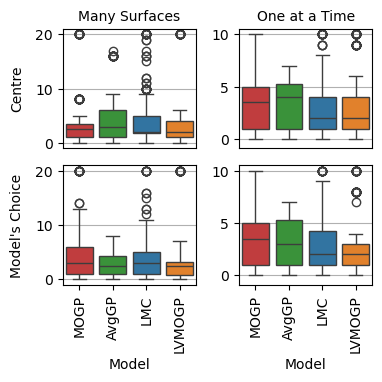

In [116]:
import seaborn as sns
linestyles = {'lmc':'dashdot', 'mo_indi': 'dotted', 'lvm':  'solid' , 'avg': 'dashed'}

total_df['order'] = total_df['model'].map({'mo_indi':1, 'avg':2, 'lmc':3, 'lvm':4})
total_df = total_df.sort_values('order')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[0.7*page_width, 0.7*page_width])
colors = fns.get_colors()
plot_minmax=True
starting_point_names = {'centre':'Centre', '0_point_start':'Model\'s Choice'}
learning_type_names = {'learning_many':'Many Surfaces', 'learning_1':'One at a Time'}
labels = {'mo_indi':'MOGP', 'avg':'AvgGP', 'lmc': 'LMC', 'lvm':'LVMOGP'}

keys_list = total_df['test_type'].unique()

for i, learning_type in enumerate(learning_types):
    for j, starting_point in enumerate(starting_points):

        name = [s for s in keys_list if learning_type in s and starting_point in s][0]
        print(name)
         
        data = totals
        # Convert the data dictionary into a DataFrame
        df = total_df[total_df['test_type'] == name]
        if learning_type == 'learning_many':
            df = df.fillna(20)
        else:
            df = df.fillna(10)

        # Create a color palette based on the color_map dictionary
        palette = [colors[category] for category in df['model'].unique()]

        # Create the boxplot using seaborn
        sns.boxplot(x='model_label', y='iteration', data=df, palette=palette, ax=axs[j, i])

        if starting_point == 'centre':
            axs[j,i].set_title(f'{learning_type_names[learning_type]}', fontsize=10)
        axs[j,i].tick_params(axis='x', rotation=90)

        # Customize the plot
        # ax.set_title(f'{name}')
        # ax.set_title(f'{name}')
        axs[0,i].set_xticklabels('')
        axs[0,i].set_xticks([])
        axs[0,i].set_xlabel('')
        axs[1,i].set_xlabel('Model')
        axs[j,i].set_ylabel('')


rows = [f'{row}' for row in starting_point_names.values()]
for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=10, ha='right', va='center', rotation=90)
    
for ax in axs.flatten():
    ax.grid(axis='y')

for ax in axs[:, 1]:
    ax.set_ylim(None, 10.5)




plt.tight_layout()
plot_path = pl.Path(os.getcwd()) / 'analysis/plots'
plt.savefig(plot_path / f'retroBO_no_experiments_boxplot_penalized.svg', bbox_inches='tight')


Below gives a dataframe of the regret of the first points

In [117]:
first_regret_df = pd.DataFrame(columns=['model', 'starting point & learning type', 'mean', 'min', 'max'])
first_regret_df['model'] = ['avg', 'mo_indi', 'lmc', 'lvm'] * 4
first_regret_df['starting point'] = ['centre'] * 4 + ['0_point_start'] * 4 + ['centre'] * 4 + ['0_point_start'] * 4
first_regret_df['learning type'] = ['learning many'] * 8 + ['learning 1'] * 8
dfs = []
for name, regret_df in regret_metrics.items():
    if 'not random' in name:
        pass
        # regret_df = regrets[learning_type][starting_point]
    else:
        for mod_name in regret_df['model'].unique():
            df_ = regret_df[(regret_df['model']==mod_name) & (regret_df['iteration'] == np.min(regret_df['iteration']))]
            new_df = pd.DataFrame(data=[[mod_name, name, df_['mean combined regret cummin'].to_numpy()[0],
                                         df_['min combined regret cummin'].to_numpy()[0],
                                         df_['max combined regret cummin'].to_numpy()[0] ]],
                                  columns=['model', 'starting point & learning type', 'mean', 'min', 'max'])
            dfs.append(new_df)

first_regret_df = pd.concat(dfs, ignore_index=True)
print(first_regret_df.to_string())
print('lvm only:')
print(first_regret_df[first_regret_df['model']== 'lvm'].to_string())

      model starting point & learning type      mean       min       max
0       avg              centre_learning_1  0.552441  0.552441  0.552441
1       lmc              centre_learning_1  0.552441  0.552441  0.552441
2       lvm              centre_learning_1  0.552441  0.552441  0.552441
3   mo_indi              centre_learning_1  0.552441  0.552441  0.552441
4       avg       0_point_start_learning_1  0.577398  0.577398  0.577398
5       lmc       0_point_start_learning_1  0.569671  0.455855  0.726202
6       lvm       0_point_start_learning_1  0.398596  0.339124  0.463268
7   mo_indi       0_point_start_learning_1  0.585703  0.504776  0.708760
8       avg           centre_learning_many  0.552441  0.552441  0.552441
9       lmc           centre_learning_many  0.552441  0.552441  0.552441
10      lvm           centre_learning_many  0.552441  0.552441  0.552441
11  mo_indi           centre_learning_many  0.552441  0.552441  0.552441
12      avg    0_point_start_learning_many  0.50306